In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR

from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(12, 8))
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.options.display.max_rows = 20

## Visualización y Análisis de la Serie Temporal

Cargamos y leemos los datos para ver que tenemos

In [ ]:
data = pd.read_csv('co2_mm_mlo.csv')
data.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.7000,314.4300,-1,-9.9900,-0.9900
1,1958,4,1958.2877,317.4500,315.1600,-1,-9.9900,-0.9900
2,1958,5,1958.3699,317.5100,314.7100,-1,-9.9900,-0.9900
3,1958,6,1958.4548,317.2400,315.1400,-1,-9.9900,-0.9900
4,1958,7,1958.5370,315.8600,315.1800,-1,-9.9900,-0.9900


Unimos el año y el mes para tener la fecha

In [ ]:
data = pd.read_csv('co2_mm_mlo.csv',
                   parse_dates={'date': ['year', 'month']},
                   index_col='date',
                   date_parser=lambda x: pd.to_datetime(x, format='%Y %m')
                   )

data.head()

,decimal date,average,deseasonalized,ndays,sdev,unc
date,,,,,,
1958-03-01,1958.2027,315.7000,314.4300,-1,-9.9900,-0.9900
1958-04-01,1958.2877,317.4500,315.1600,-1,-9.9900,-0.9900
1958-05-01,1958.3699,317.5100,314.7100,-1,-9.9900,-0.9900
1958-06-01,1958.4548,317.2400,315.1400,-1,-9.9900,-0.9900
1958-07-01,1958.5370,315.8600,315.1800,-1,-9.9900,-0.9900


In [ ]:
# create a time series
st = pd.Series(data['average'].values, index=data.index)

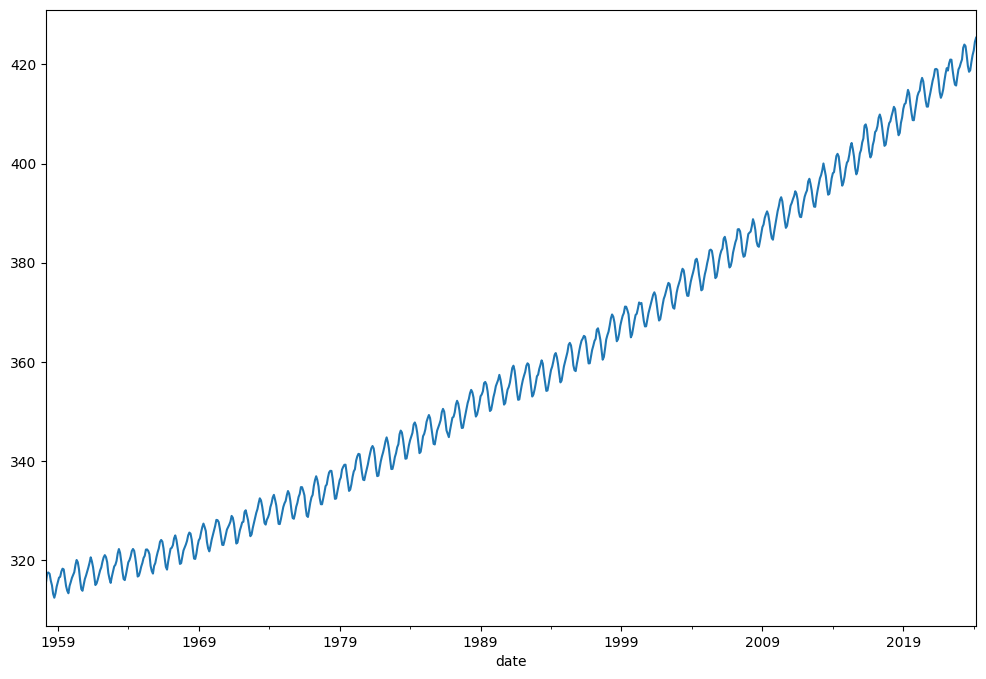

In [ ]:
# basic plot
st.plot();

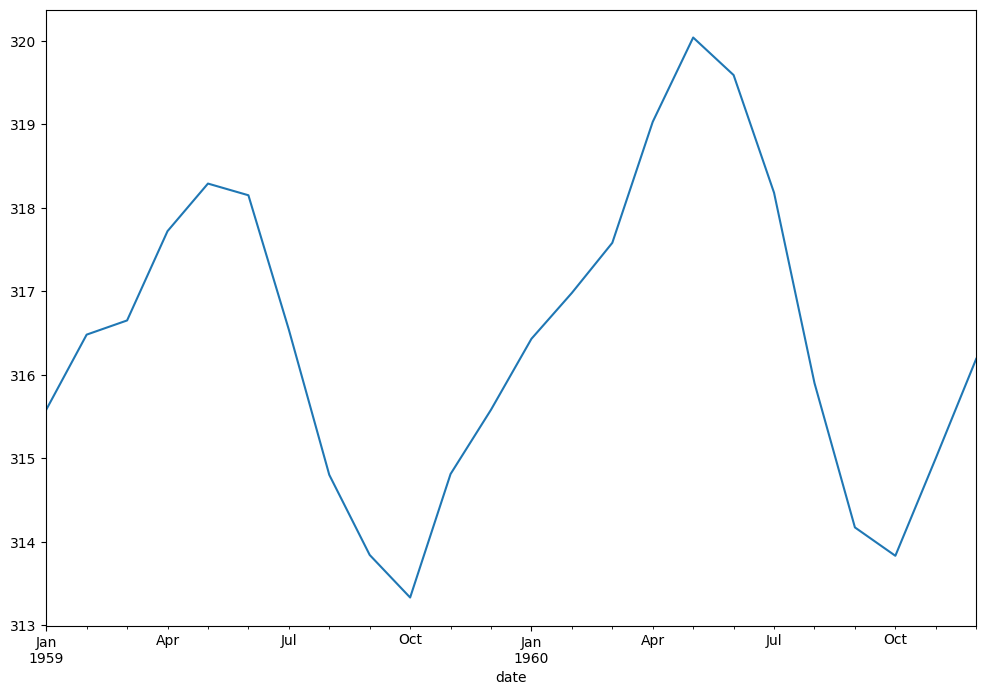

In [ ]:
st_3_years = st['1959':'1960']
st_3_years.plot();

Al observar la serie temporal, podemos notar que hay una tendencia de crecimiento y también ciclado. Cada año, podemos observar un aumento en la concentración de CO2.

Además, si graficamos solo dos años podemos ver el patrón cíclico, donde la concentración de CO2 tiende a aumentar hasta aproximadamente junio y luego disminuir hasta fin de año, y así sucesivamente.

## Resultados de la Prueba de Estacionariedad

Es notorio que la serie no es estacionaria, pero igual realizaremos la prueba

In [ ]:
def test_stationarity(timeseries, significance_level=0.05):
    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, color='red', label='Media Móvil')
    plt.plot(rolstd, color='black', label='Desviación Estándar Móvil')
    plt.legend(loc='best')
    plt.show()

    # Dickey-Fuller test
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }

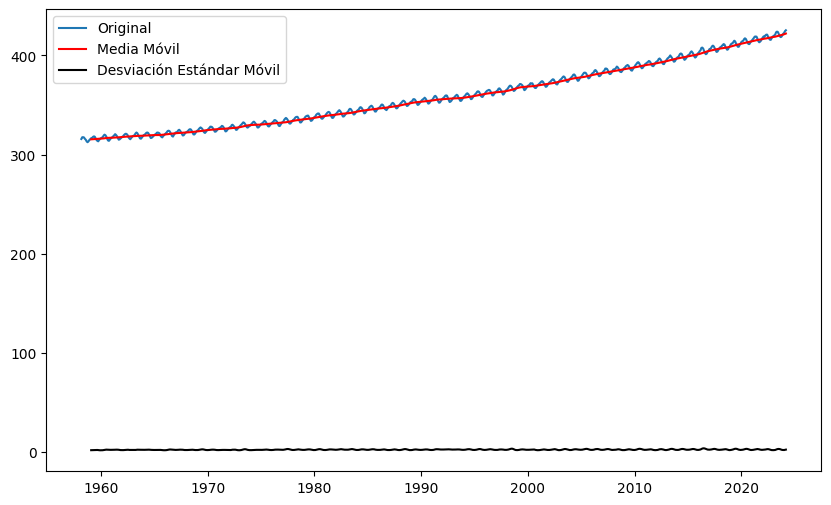

{'ADF Statistic': 6.204525491050945,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.4388599939707056,
  '5%': -2.865295977855759,
  '10%': -2.5687700561872413},
 'Is Stationary (p-value)': False,
 'Is Stationary (ADF)': False,
 'Is Stationary (Both)': False}

In [ ]:
adf_test_results = test_stationarity(st)
adf_test_results

Como deciamos efectivamente no es estacioanria ya que el estadístico ADF de 6.2045 es mayor que cualquiera de los valores críticos y el p-value también es muy alto, entonces no podemos rechazar la hipótesis nula.


## Proceso de Diferenciación

In [ ]:
def make_stationary_recursive(time_series, significance_level=0.05, max_diff=10):
    """
    Estacionaliza una serie de tiempo mediante diferenciación recurrente y
    verifica su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser procesados.
    significance_level (float): El nivel de significancia para la prueba ADF (por defecto es 0.05).
    max_diff (int): El número máximo de diferenciaciones a aplicar.

    Retorna:
    tuple: Una tupla conteniendo el número de diferenciaciones aplicadas (d),
           la serie de tiempo diferenciada y los resultados de la prueba ADF.
    """
    d = 0  # Contador de diferenciaciones
    diff_series = time_series.copy()

    for i in range(max_diff):
        adf_test_results = test_stationarity(diff_series, significance_level)
        if adf_test_results['Is Stationary (Both)']:
            break
        else:
            diff_series = diff_series.diff().dropna()
            d += 1

    return d, diff_series, adf_test_results

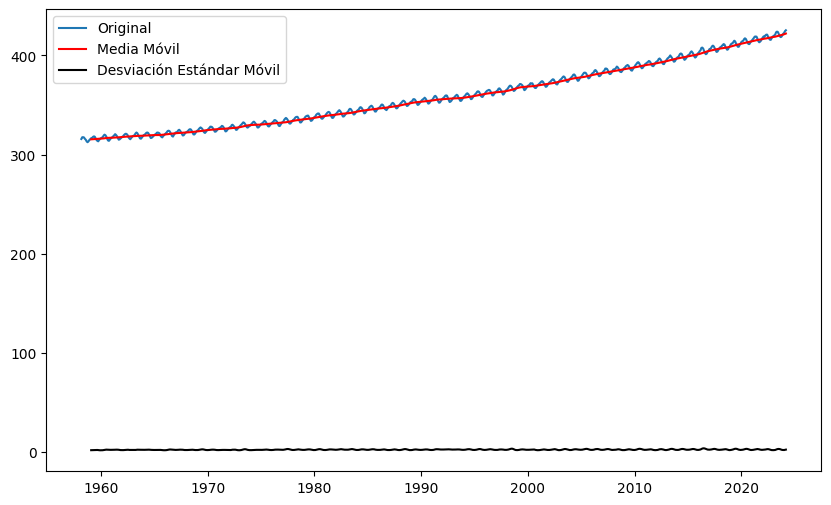

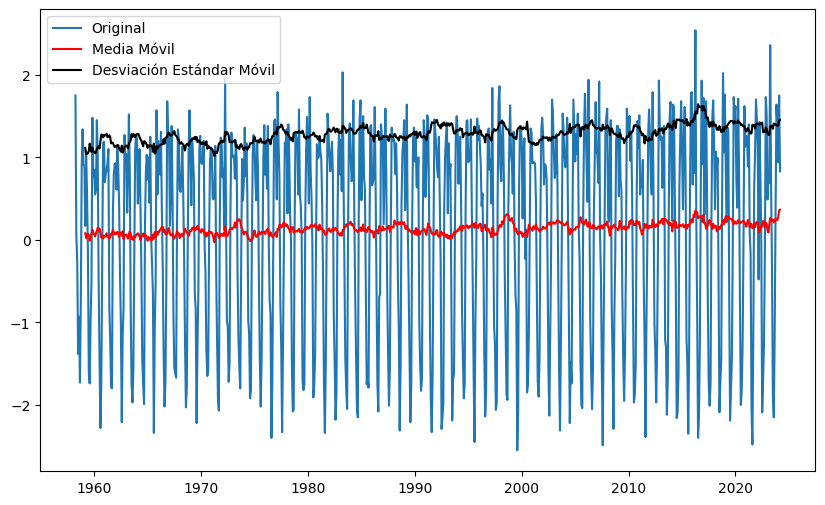

(1,
 {'ADF Statistic': -5.238158439989755,
  'p-value': 7.344619920330655e-06,
  'Critical Values': {'1%': -3.4388710830827125,
   '5%': -2.8653008652386576,
   '10%': -2.568772659807725},
  'Is Stationary (p-value)': True,
  'Is Stationary (ADF)': True,
  'Is Stationary (Both)': True})

In [ ]:
d_count, diff_series, adf_results = make_stationary_recursive(st)
d_count, adf_results

Podemos observar que con la función para hacer estacionaria la seria se aplicó una sola diferenciación y que fue efectiva para alcanzar la estacionariedad, teniendo en cuenta los resultados de la prueba de Dickey-Fuller Aumentada.

El p-value es más pequeño que 0.05 y el estadístico ADF es menor que los valores críticos, lo que confirma la estacionariedad de la serie. Por lo tanto, la aplicación de una sola diferenciación fue efectiva para transformar la serie original en una estacionaria.

## Selección de Parámetros del Modelo ARIMA

In [ ]:
# Separando la serie de tiempo diferenciada en conjuntos de entrenamiento, validación y prueba
train_size = int(len(diff_series) * 0.4)
val_size = int(len(diff_series) * 0.3)
train, val, test = diff_series[:train_size], diff_series[train_size:train_size+val_size], diff_series[train_size+val_size:]

len(train), len(val), len(test)

(316, 237, 239)

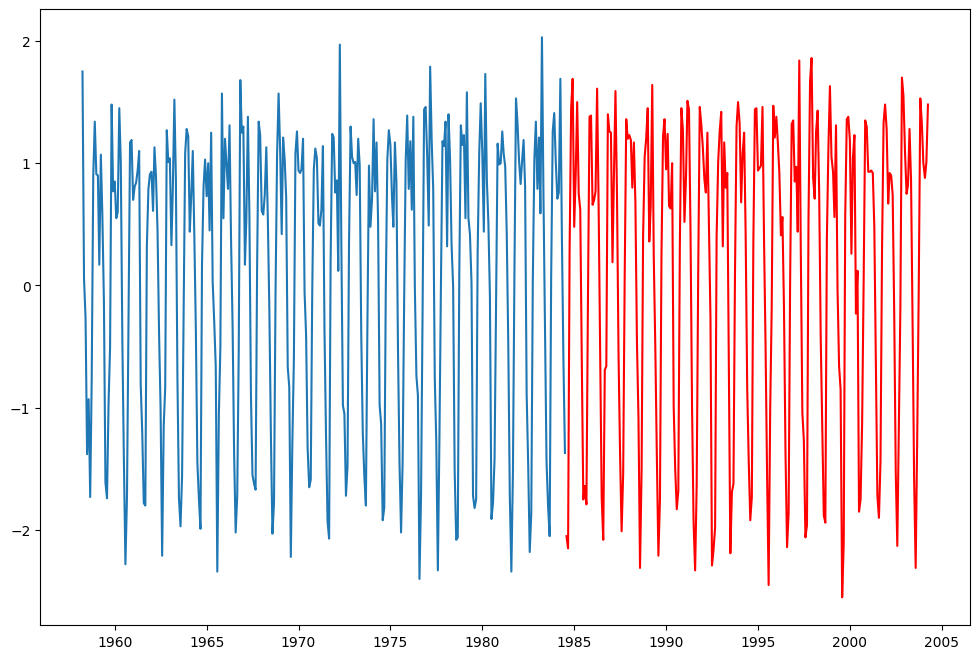

In [ ]:
# plot train-test split of time series data
plt.plot(train)
plt.plot(val, color='r');

### Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)

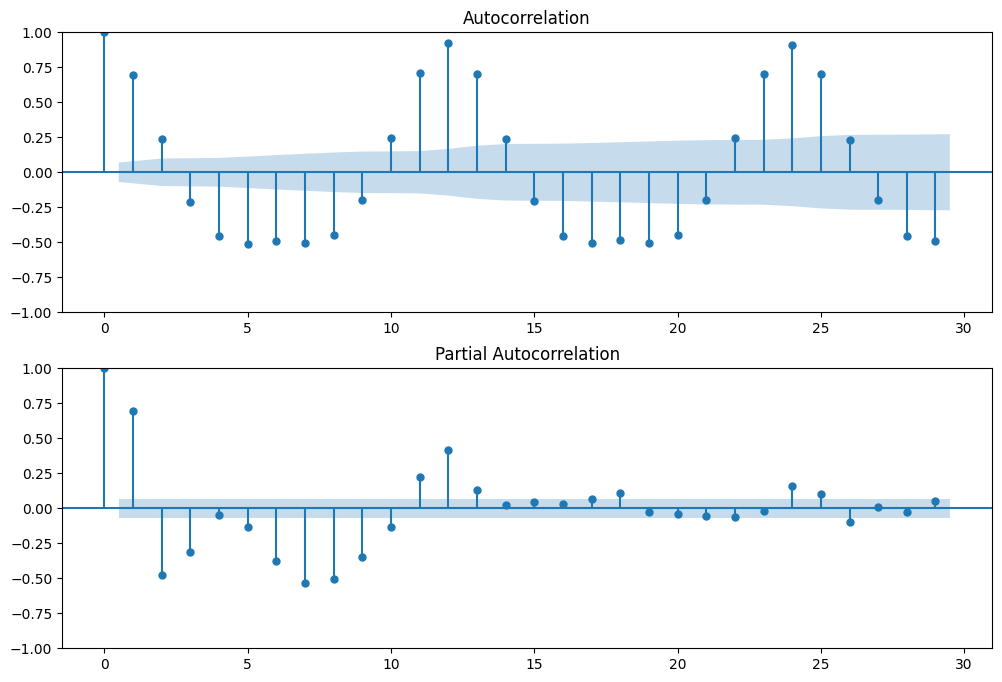

In [ ]:
plt.subplots(figsize=(12, 8))
plt.subplot(211)
plot_acf(diff_series, ax=plt.gca())

plt.subplot(212)
plot_pacf(diff_series, ax=plt.gca())
plt.show()

Teniendo en cuenta las gráficas de ACF y PACF vamos a listar los valores de p y q para realizar el proceso de entrenar todas las posibles combinaciones de ARIMA y luego seleccionar el modelo con el menor AIC

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(1, 15, 1)
qs = range(1, 20, 1)
d = 0

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train, order_list, d)
print(result_df)

En este caso con un p=9 y q=11 nos dio el menor AIC y por lo tanto, vamos a ajustar el modelo ARIMA con esos parámetros y luego lo visualizaremos

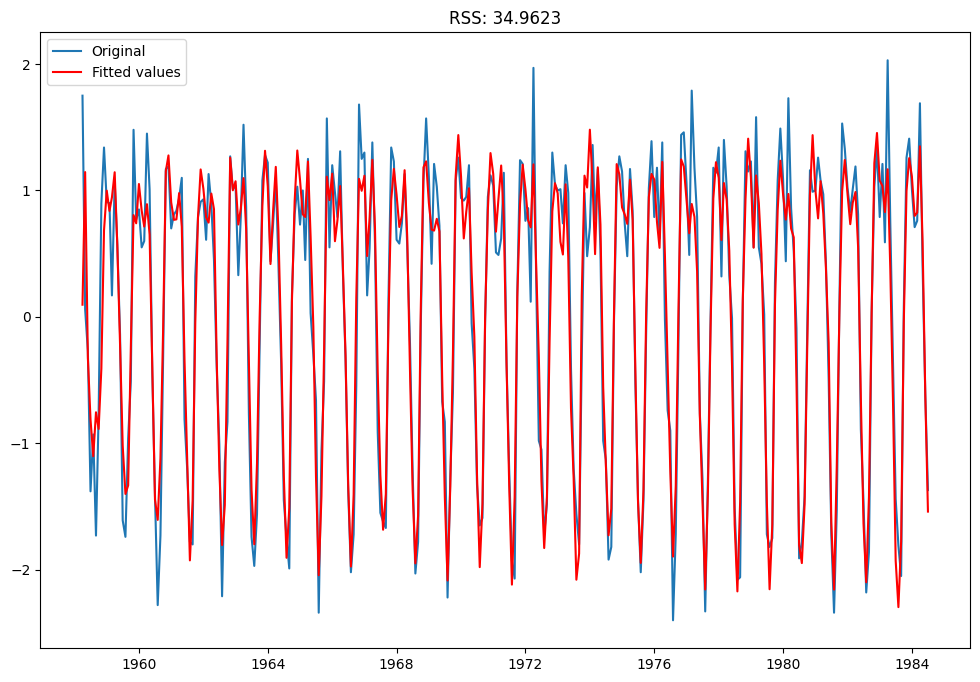

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  316
Model:                ARIMA(9, 0, 11)   Log Likelihood                 -78.494
Date:                Tue, 30 Apr 2024   AIC                            200.988
Time:                        17:45:08   BIC                            283.614
Sample:                    04-01-1958   HQIC                           233.996
                         - 07-01-1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0964      0.009     10.154      0.000       0.078       0.115
ar.L1          0.3179      4.253      0.075      0.940      -8.017       8.653
ar.L2         -0.6478      5.433     -0.119      0.9

In [ ]:
# Ajustando el modelo ARIMA
model = ARIMA(train, order=(9, 0, 11))
results = model.fit()

# Visualización de la serie de entrenamiento y los valores ajustados
plt.figure(figsize=(12, 8))
plt.plot(train, label='Original')
plt.plot(results.fittedvalues, color='red', label='Fitted values')
plt.title('RSS: %.4f' % sum((results.fittedvalues - train)**2))
plt.legend()
plt.show()

print(results.summary())

Note que el RSS fue de 34.96 dandonos a entender que el modelo ARIMA(9, 0, 11) ajusta bien los datos de entrenamiento, ya que la discrepancia entre los valores observados y los valores predichos es relativamente baja.

Ahora vamos a ver el análisis residual:

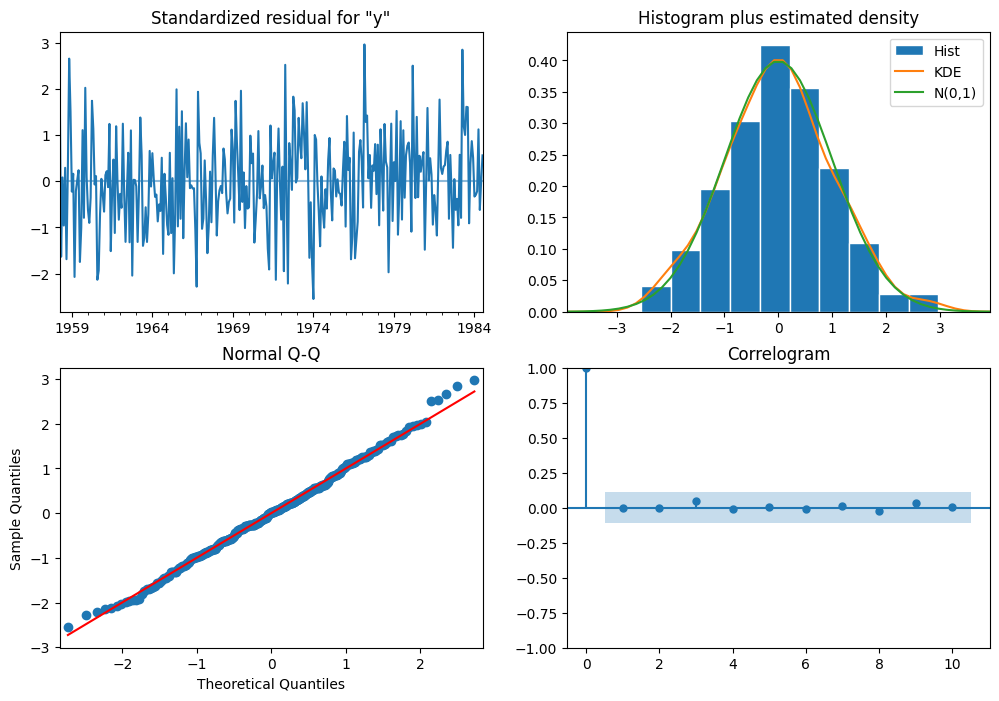

In [ ]:
results.plot_diagnostics(figsize=(12,8));

Podemos observar que el Q-Q plot sugiere que los residuos tienen una distribución normal, ya que los residuos no se desvían significativamente de la línea recta.

Por otro lado, la gráfica de autocorrelación en los residuaos, podemos ver que los residuos se mantienen dentro de los intervalos de confianza y no hay dependencia entre ellos, lo que sugiere que cualquier autocorrelación observada no es significativa. Teniendo en cuenta esto estamos listos para el forecast.

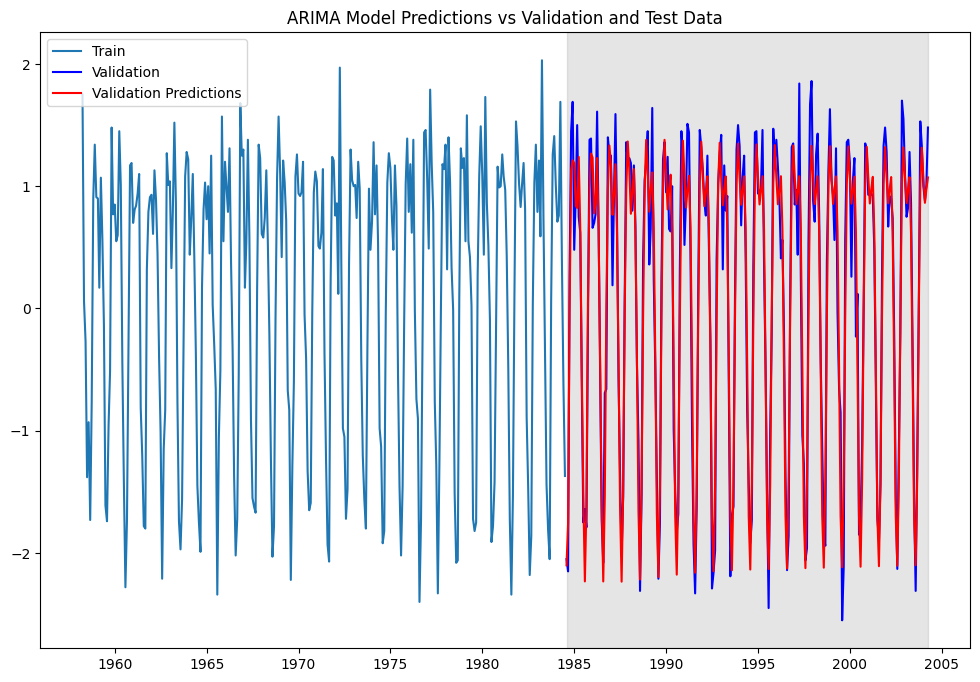

(0.10858852015940264, 0.32952772289961074)

In [ ]:
# Pronóstico en el conjunto de validación
predictions_val = results.get_forecast(steps=len(val))
predicted_mean_val = predictions_val.predicted_mean
predicted_series_val = pd.Series(predicted_mean_val, index=val.index)

# Pronóstico en el conjunto de prueba
#predictions_test = results.get_forecast(steps=len(test))
#predicted_mean_test = predictions_test.predicted_mean
#predicted_series_test = pd.Series(predicted_mean_test, index=test.index)

# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train, label='Train')
ax.plot(val, label='Validation', color='blue')
#ax.plot(test, label='Test', color='blue')
ax.plot(predicted_series_val, label='Validation Predictions', color='red')
#ax.plot(predicted_series_test, label='Test Predictions', color='red')
ax.legend(loc='best')
ax.set_title('ARIMA Model Predictions vs Validation and Test Data')

# Resaltar los períodos de validación y prueba en la gráfica
fecha_inicio_val = val.index[0]
fecha_fin_val = val.index[-1]
ax.axvspan(fecha_inicio_val, fecha_fin_val, color='#808080', alpha=0.2)

#fecha_inicio_test = test.index[0]
#fecha_fin_test = test.index[-1]
#ax.axvspan(fecha_inicio_test, fecha_fin_test, color='#808080', alpha=0.2)

plt.show()

mse_val = mean_squared_error(val, predicted_series_val)
rmse_val = np.sqrt(mse_val)

#predicted_series_test = predicted_series_test.dropna()

#mse_test = mean_squared_error(test.loc[predicted_series_test.index], predicted_series_test)
#rmse_test = np.sqrt(mse_test)

mse_val, rmse_val

In [ ]:
wdef rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []
    pred_ARIMA_2 = []

    for i in tqdm_notebook(range(train_len, total_len, window)):
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(window)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(val)
WINDOW = 8

pred_ARIMA = rolling_forecast(diff_series, TRAIN_LEN, HORIZON, WINDOW, (9, 0, 11))
fechas = val.index
st_pred_ARIMA = pd.Series(pred_ARIMA[:len(fechas)], index=fechas)

mse = mean_squared_error(val, st_pred_ARIMA)
rmse = np.sqrt(mse)

mse, rmse

  0%|          | 0/30 [00:00<?, ?it/s]

(0.11435528983797771, 0.3381645898641336)

(0.11435528983797771, 0.3381645898641336)

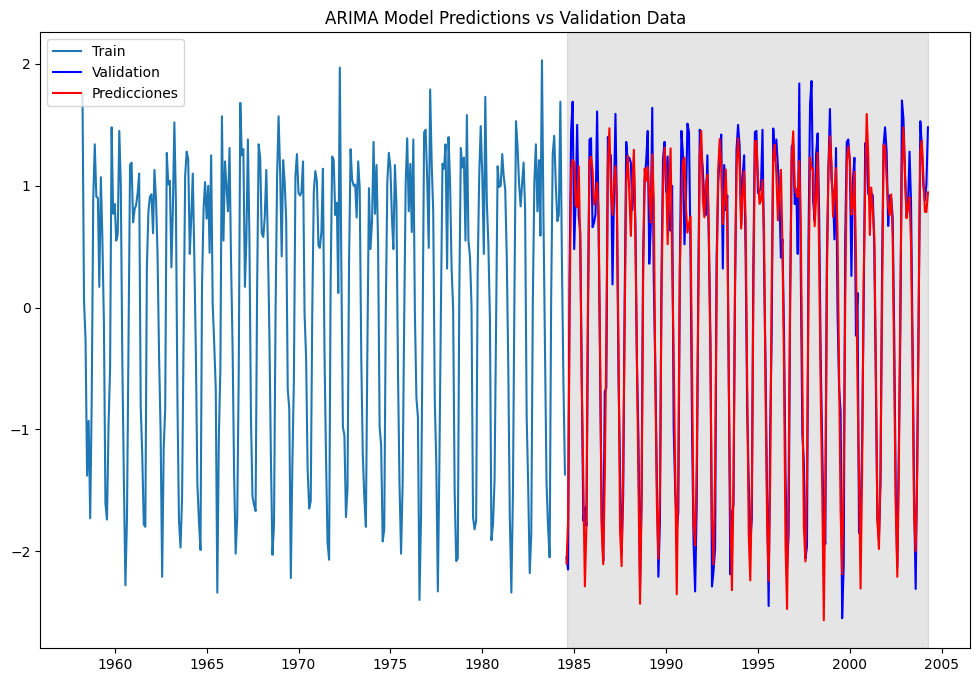

In [ ]:
# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train,label='Train')
ax.plot(val, label='Validation', color='blue')
ax.plot(st_pred_ARIMA, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('ARIMA Model Predictions vs Validation Data')

fecha_inicio = val.index[0]
fecha_fin = val.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)

mse = mean_squared_error(val, st_pred_ARIMA)
rmse = np.sqrt(mse)

mse, rmse